# Embedding a Recurrent Neural Network in an FMU

Created by [Michele Urbani](mailto:murbani@fbk.eu) on 09/04/2025.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split


RAW_DATA_DIR = Path("heat-propagation-data")
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)


## Simulating heat propagation in a squared plate

In [2]:
# Plate dimensions and simulation parameters
Lx, Ly = 10.0, 10.0   # Length and width of the plate
Nx, Ny = 50, 50       # Number of grid points in x and y directions
dx = Lx / Nx          # Spatial step size in x direction
dy = Ly / Ny          # Spatial step size in y direction
alpha = 0.9           # Thermal diffusivity
dt = 0.01             # Time step size
T = 25.0             # Total simulation time
T_impulse = T         # Duration of the heat impulse
T_ini = 0.0         # Initial temperature everywhere

# Staircase pulse parameters
num_steps = 5         # Number of steps in the staircase
max_temp = 200.0      # Maximum temperature during impulse
step_duration = T_impulse / num_steps  # Duration of each step

# Time-stepping parameters
Nt = int(T / dt)      # Number of time steps
Nt_impulse = int(T_impulse / dt)  # Number of steps for the impulse

# Function to compute the next time step using finite differences
def step(u, alpha, dx, dy, dt, n):
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            u[n, i, j] = u[n - 1, i, j] + alpha * dt * (
                (u[n - 1, i + 1, j] - 2*u[n - 1, i, j] + u[n - 1, i - 1, j]) / dx**2 +
                (u[n - 1, i, j+1] - 2*u[n - 1, i, j] + u[n - 1, i, j-1]) / dy**2
            )

def run_simulation(alpha, u, T_ini):
    """
    Parameters
    ----------
    alpha : float
        Thermal diffusivity of the plate.
    u : np.ndarray
        Temperature profile at each time step.
    T_ini : float
        Initial temperature of the plate.
    """
    # Initialize the temperature grid
    y = np.zeros((Nt, Nx, Ny))
    # Initial condition: zero everywhere
    y[0] = T_ini
    # Time-stepping loop
    for n in range(1, Nt):
        # Apply heat impulse on the left boundary (x = 0)
        y[n, :, 0] = u[n]
        # Update temperature across the plate
        step(y, alpha, dx, dy, dt, n)
    # Return only the temperature profile at the center of the plate
    return y[:, Nx//2, Ny//2]

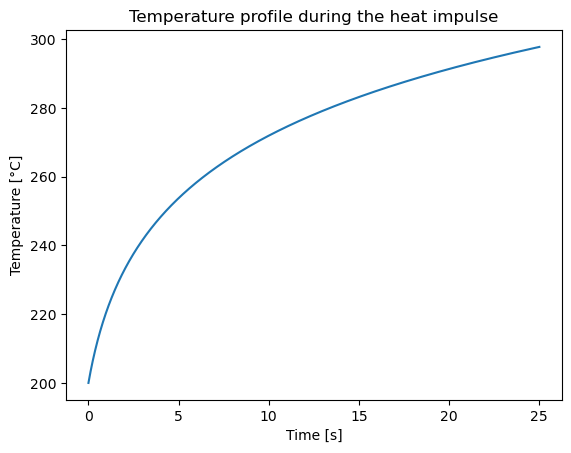

In [3]:
 # Time vector
t = np.linspace(0, T, Nt)
# The initial temperature value
T_ini = 200.0
# Define a temperature profile for the heat impulse
u = 30 * np.log(t + 1) + T_ini
# Plot the temperature profile
plt.plot(t, u)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature profile during the heat impulse')
plt.show()

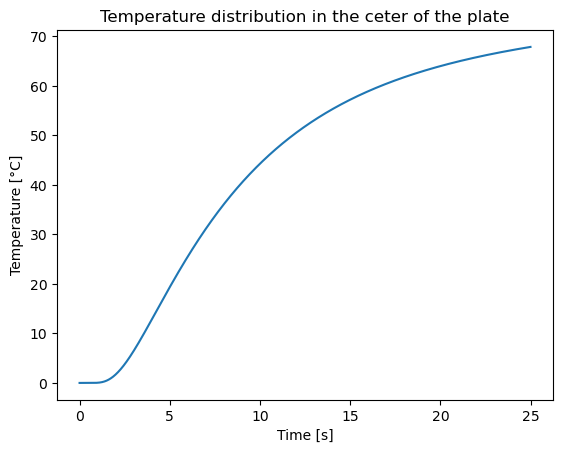

In [4]:
T_plate = 0.0
# Run an example simulation
y = run_simulation(alpha, u, T_plate)
# Plot the temperature distribution at different time steps
fig, ax = plt.subplots()
ax.plot(y)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.set_title('Temperature distribution in the ceter of the plate')
ax.set_xticks(np.arange(0, 6, 1) * 500)
ax.set_xticklabels(np.arange(0, 6, 1) * 5)
plt.show()

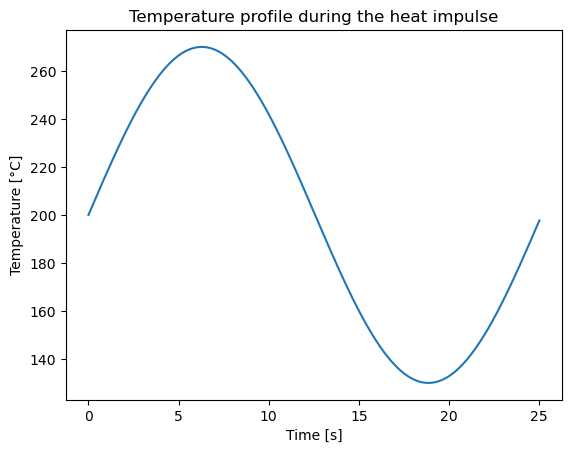

In [5]:
 # Time vector
t = np.linspace(0, T, Nt)
# The initial temperature value
T_ini = 200.0
# Define a temperature profile for the heat impulse
u = 70 * np.sin(t / 4) + T_ini
# Plot the temperature profile
plt.plot(t, u)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature profile during the heat impulse')
plt.show()

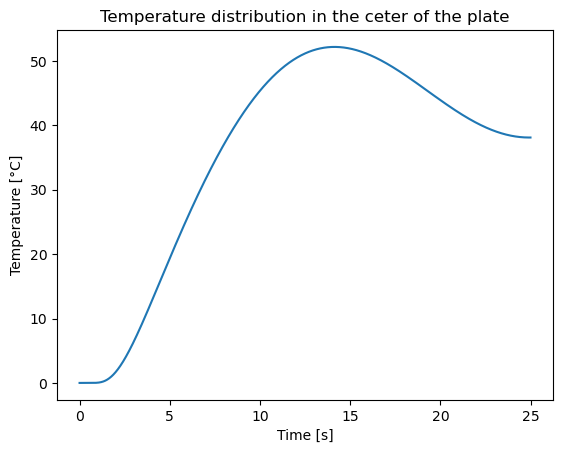

In [6]:
T_plate = 0.0
# Run an example simulation
y = run_simulation(alpha, u, T_plate)
# Plot the temperature distribution at different time steps
fig, ax = plt.subplots()
ax.plot(y)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.set_title('Temperature distribution in the ceter of the plate')
ax.set_xticks(np.arange(0, 6, 1) * 500)
ax.set_xticklabels(np.arange(0, 6, 1) * 5)
plt.show()

## Generate data to train the model

Data are generate using only sine and cosine functions.

In [7]:
# Time duration
T = 50.0
# Time step size
dt = 0.01
# Number of time steps
Nt = int(T / dt)
# Time steps
t = np.linspace(0, T, Nt)
# Array to store the temperature profiles
U = []

T_ini = 100.0
T_plate = 50.0

M = 40

# GENERATE SINUSOIDAL FUNCTIONALS
for i in range(M):
    u = (-1)**i * 20 * i * np.sin(t / 8 + i * np.pi / 8) + T_ini
    U.append({
        "alpha": alpha,
        "T_plate": T_plate,
        "u": u
    })

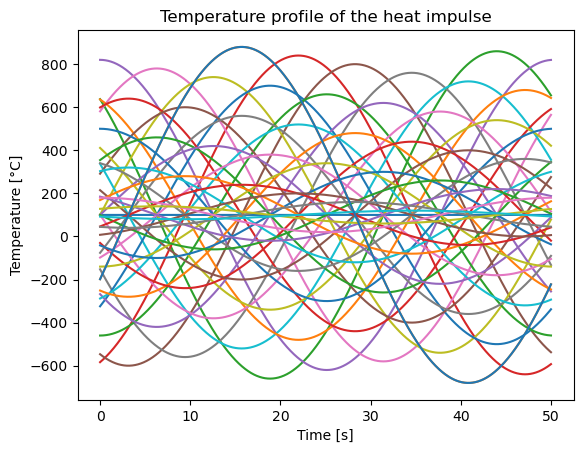

In [8]:
# Plot a temperature profile
for i in range(M):
    plt.plot(t, U[-i]["u"])
plt.plot(t, U[-1]["u"])
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature profile of the heat impulse')
plt.show()

In [9]:
# Empty list to store the temperature profiles
Y = []
# Run the simulation for each temperature profile
for u in U:
    y = run_simulation(u["alpha"], u["u"], u["T_plate"])
    Y.append(y)

In [10]:
# Include alpha and the initial plate temperature in the datasets
# Generate dataset for the parameters alpha and T_plate
X = []
for u in U:
    X.append([u["alpha"], u["T_plate"]])
params = pd.DataFrame(X, columns=["alpha", "T_plate"])
params.to_csv(RAW_DATA_DIR / "params.csv", index=False)

In [11]:
# Save input/output data
for i, y in enumerate(Y):
    data = pd.DataFrame({
        "time": t,
        "u": U[i]["u"],
        "y": y,
        "alpha": U[i]["alpha"] * np.ones_like(y),
        "T_plate": U[i]["T_plate"] * np.ones_like(y)
    })
    data.to_csv(RAW_DATA_DIR / f"case_{i}.csv", index=False)

## Train the RNN


### Create PyTorch datdaset

In [12]:
# Read data
data_files = sorted(RAW_DATA_DIR.glob("case_*.csv"))
data = []
for file in data_files:
    df = pd.read_csv(file)
    data.append(df)

seq_length = 200  # Number of time steps to look back

class HeatPropagationDataset(Dataset):

    def __init__(self, data, seq_length):
        X, Y = [], []
        for series in data:
            x = series["u"].values
            y = series["y"].values
            # Create sequences of input and output data
            for i in range(len(x) - seq_length):
                X.append(x[i:i+seq_length])
                Y.append(y[i+seq_length])
        # Convert to numpy arrays
        x = np.array(X).astype(np.float32)
        y = np.array(Y).astype(np.float32)

        # Save normalization parameters
        self.x_min = np.min(x)
        self.x_max = np.max(x)
        self.y_min = np.min(y)
        self.y_max = np.max(y)

        # Normalize the input data
        self.x = (x - self.x_min) / (self.x_max - self.x_min + 1e-3)
        # Normalize the output data
        self.y = (y - self.y_min) / (self.y_max - self.y_min + 1e-3)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### Declare the LSTM model

In [13]:
class HeatRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(HeatRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        out = self.fc(out)  # Predict next time step
        return out, h

# Model parameters
input_size = seq_length
hidden_size = 64
output_size = 1
num_layers = 2

model = HeatRNN(input_size, hidden_size, output_size, num_layers)

### Prepare for training...

In [14]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20
BATCH_SIZE = 10

# Split files into training and testing datasets
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

train_dataset = HeatPropagationDataset(train_data, seq_length)
test_dataset = HeatPropagationDataset(test_data, seq_length)

# Create DataLoader for training
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# initialize the hidden state
hidden = None


### ... and train the LSTM

In [15]:
# Set model train
model.train()

for _ in tqdm(range(EPOCHS), ncols=80):
    for x, y in train_dataloader:
        # Zero gradients
        optimizer.zero_grad()
        # Outputs from the rnn
        prediction, _ = model(x, hidden)
        # Calculate the loss
        loss = loss_fn(prediction.squeeze(-1), y)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

# Save the model
torch.save(model.state_dict(), "example3.pt")

100%|███████████████████████████████████████████| 20/20 [11:09<00:00, 33.49s/it]


### Predictions

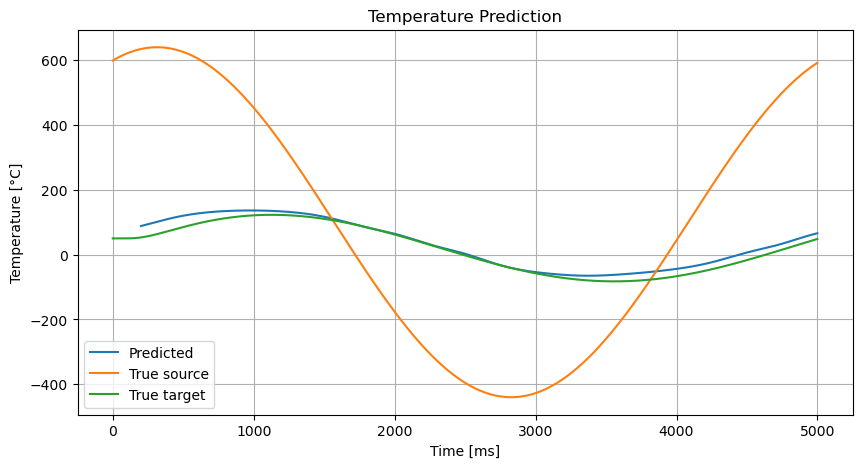

In [16]:
# Use the model to predict
model.eval()
data = test_data.dataset[20]
predictions = []
# Normalize the input data
X = (data['u'].values - train_dataset.x_min) / (train_dataset.x_max - train_dataset.x_min + 1e-3)
for i in range(len(X) - seq_length):
    # Cast to tensor
    x = torch.tensor(X[i:i + seq_length], dtype=torch.float32).unsqueeze(0)
    # Outputs from the rnn
    prediction, _ = model(x, hidden)
    # Denormalize the output data
    prediction = prediction * (train_dataset.y_max - train_dataset.y_min + 1e-3) + train_dataset.y_min
    # Append predictions to the list
    predictions.append(prediction.squeeze(-1).detach().numpy())

# Concatenate all predictions
predictions = np.concatenate(predictions, axis=0)

# Plot the predictions
plt.figure(figsize=(10, 5))
plt.plot(np.arange(seq_length, len(X)), predictions, label="Predicted")
plt.plot(data['u'], label="True source")
plt.plot(data['y'], label="True target")
plt.xlabel("Time [ms]")
plt.ylabel("Temperature [°C]")
plt.title("Temperature Prediction")
plt.grid()
plt.legend()
plt.show()

The LSTM model works fine for demonstration purposes and we decide not to refine the model further.

In [17]:
# Save predictions for the proceeding paper
df = pd.DataFrame({"true": data['y'].values[seq_length:], "predicted": predictions})
df['time'] = np.arange(seq_length / 2, len(df) / 2 + seq_length / 2, 0.5)
df.reset_index(drop=True, inplace=True)
df.set_index('time', inplace=True)
df.to_csv("predictions.csv", index=True)

## Wrap the model for ONNX export

### Add model internal memory, memory update, and standardization

#### Tweak `forward` to update the memory

This tweak is specific for applications in the context of FMI simulations,
where time is advanced according to a given time step that corresponds with
the sampling of data, and guarantees that new data are compliant with the
already existing trajectories.

In [64]:
class LSTMWrapper(nn.Module):

    def __init__(self, lstm_model, norm_params):
        super(LSTMWrapper, self).__init__()
        self.lstm_model = lstm_model
        self.x_min, self.x_max, self.y_min, self.y_max = norm_params
        # self.register_buffer("x", torch.full((1, seq_length, 1), torch.nan))
        self.x = torch.zeros((1, seq_length, 1), dtype=torch.float32)

    def forward(self, x):
        # Normalize the input data
        x = (x - self.x_min) / (self.x_max - self.x_min + 1e-3)
        # Initialize the memory state
        # self.x = torch.where(torch.isclose(), x, self.x)
        # Reshape x
        x = x.unsqueeze(0).unsqueeze(-1)
        # Update the memory state
        self.x = torch.cat((self.x[:, 1:, :], x), dim=1)
        # Pass through LSTM model
        prediction, _ = self.lstm_model(self.x.squeeze(-1))
        # Denormalize the output data
        prediction = prediction * (self.y_max - self.y_min + 1e-3) + self.y_min
        return prediction.squeeze(-1)


In [65]:
# Initialize the old model from existing weight
model = HeatRNN(input_size, hidden_size, output_size, num_layers)
# Load the weights
model.load_state_dict(torch.load("example3.pt"))

# Create the new model
model_wrapper = LSTMWrapper(
    model,
    (train_dataset.x_min, train_dataset.x_max, train_dataset.y_min, train_dataset.y_max)
)

model_wrapper.eval()

LSTMWrapper(
  (lstm_model): HeatRNN(
    (rnn): RNN(200, 64, num_layers=2, batch_first=True)
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
)

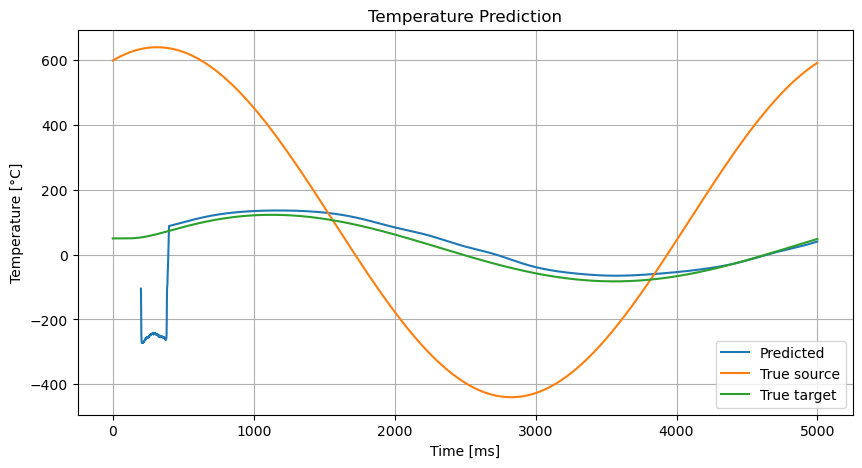

In [66]:
# Use the model to predict
predictions = []
X = data['u'].values
for i in range(len(X) - seq_length):
    # Cast to tensor
    x = torch.tensor(X[i], dtype=torch.float32).unsqueeze(0)
    # Outputs from the rnn
    prediction = model_wrapper(x)
    # Append predictions to the list
    predictions.append(prediction.squeeze(-1).detach().numpy())

# Concatenate all predictions
predictions = np.array(predictions)

# Plot the predictions
plt.figure(figsize=(10, 5))
plt.plot(np.arange(seq_length, len(X)), predictions, label="Predicted")
plt.plot(data['u'], label="True source")
plt.plot(data['y'], label="True target")
plt.xlabel("Time [ms]")
plt.ylabel("Temperature [°C]")
plt.title("Temperature Prediction")
plt.grid()
plt.legend()
plt.show()

## Export the model to ONNX

In [67]:
import onnx

# Export the model to the ONNX format
dummy_input = torch.randn(1)
onnx_model_path = "example3.onnx"

torch.onnx.export(
    model_wrapper,
    (dummy_input, ),
    onnx_model_path,
    export_params=True,
    verbose=True,
    input_names=['input'],
    output_names=['output']
)

Exported graph: graph(%input : Float(1, strides=[1], requires_grad=0, device=cpu),
      %lstm_model.fc.weight : Float(1, 64, strides=[64, 1], requires_grad=1, device=cpu),
      %lstm_model.fc.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %onnx::RNN_91 : Float(1, 64, 200, strides=[12800, 200, 1], requires_grad=0, device=cpu),
      %onnx::RNN_92 : Float(1, 64, 64, strides=[4096, 64, 1], requires_grad=0, device=cpu),
      %onnx::RNN_93 : Float(1, 128, strides=[128, 1], requires_grad=0, device=cpu),
      %onnx::RNN_97 : Float(1, 64, 64, strides=[4096, 64, 1], requires_grad=0, device=cpu),
      %onnx::RNN_98 : Float(1, 64, 64, strides=[4096, 64, 1], requires_grad=0, device=cpu),
      %onnx::RNN_99 : Float(1, 128, strides=[128, 1], requires_grad=0, device=cpu)):
  %/Constant_output_0 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={-680}, onnx_name="/Constant"](), scope: __main__.LSTMWrapper:: # /tmp/ipykernel_21821/3843064202.py:12:0
  %/Sub_output_0 : 

## Generate the FMU

In [59]:
from onnx2fmu.app import build

build(
    model_path=onnx_model_path,
    model_description_path="example3Description.json",
)

2025-04-11 17:45:41.600 | INFO     | onnx2fmu.app:build:558 - Call cmake -S example3 -B example3/build -D MODEL_NAME=example3 -D FMI_VERSION=2


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Downloading ONNX Runtime from https://github.com/microsoft/onnxruntime/releases/download/v1.20.1/onnxruntime-linux-x64-1.20.1.tgz


FMI_PLATFORM: linux64
2025-04-11 17:45:43.980 | INFO     | onnx2fmu.app:build:560 - CMake build cmake --build example3/build --config Release


-- ONNX Runtime extraction successful.
-- Configuring done (2.3s)
-- Generating done (0.0s)
-- Build files have been written to: /home/miki/onnx2fmu/tests/example3/example3/build
[ 20%] Building C object CMakeFiles/example3.dir/example3/model.c.o
[ 40%] Building C object CMakeFiles/example3.dir/src/fmi2Functions.c.o
[ 60%] Building C object CMakeFiles/example3.dir/src/cosimulation.c.o
[ 80%] Building C object CMakeFiles/example3.dir/src/ortUtils.c.o
[100%] Linking C shared library temp/example3/binaries/linux64/example3.so
modelDescription.xml
binaries
binaries/linux64
binaries/linux64/libonnxruntime.so.1.20.1
binaries/linux64/libonnxruntime_providers_shared.so
binaries/linux64/libonnxruntime.so.1
binaries/linux64/example3.so
binaries/linux64/libonnxruntime.so
sources
sources/model.h
sources/cosimulation.h
sources/config.h
sources/ortUtils.h
sources/cosimulation.c
sources/onnxruntime_c_api.h
sources/fmi2Functions.c
sources/model.c
sources/all.c
resources
resources/model.onnx
[100%] Bui

In [58]:
# Save input to test the FMU
df = pd.DataFrame({"input_0": data['u'].values,})
df['time'] = np.arange(seq_length / 2, len(data['u'].values) / 2 + seq_length / 2, 0.5)
df.reset_index(inplace=True, drop=True)
df.set_index("time", inplace=True)
df.to_csv("input.csv", index=True)